# Legacy Simulation (Kept for Reference): Deprecated

Superceded by the updated __opsim__ notebook.




In [1]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2
# Standard imports and utility ---

import  sys

import numpy as np
import matplotlib.pyplot as plt
import simpy


# ----------------------------------------------------
print("Path:")
print("-------------------------------------")
for path_part in sys.path:
    if path_part!='': print(f'''{path_part}''')


# ---
import  lusee

# astro/observation wrapper classes
from    nav   import *

# hardware modules
from hardware.parts import *; from hardware.panels import *;from hardware.controller import *; from hardware.battery import *

# ---
print(f'''simpy: {simpy.__version__}, lusee: {lusee.__version__}''')


Path:
-------------------------------------
/home/maxim/projects/lusee/opsim/notebooks
/home/maxim/projects/lusee
/home/maxim/projects/lusee/luseepy
/home/maxim/projects/lusee/opsim
/home/maxim/.virtualenvs/lusee-simpy
/usr/lib/python310.zip
/usr/lib/python3.10
/usr/lib/python3.10/lib-dynload
/home/maxim/.virtualenvs/lusee-simpy/lib/python3.10/site-packages
simpy: 4.0.2, lusee: 1.2-dev


In [2]:
import os

print('Current directory:', os.getcwd())


sun_cachefile           = '../data/2025-02-04_03-07.npy'
mySun = Sun()
mySun.read_trajectory(sun_cachefile)
print(f'''Number of points read from the file {sun_cachefile}: {mySun.N}''')
sun = mySun.xyz # altaz2xyz(mySun.alt, mySun.az)
hrs = mySun.hrsFromSunrise


Current directory: /home/maxim/projects/lusee/opsim/notebooks
Number of points read from the file ../data/2025-02-04_03-07.npy: 2993


In [ ]:
# ARCHIVE
# Power profile file -- kept for reference. Added calculation based on the Sun position, to this notebook
# power_cachefile         = '../data/2025-02-04_03-07_power.npy'
# ---
# Temperature curve file -- kept for reference.The temperature curve calculation was added to the Sun class
# temperature_cachefile   = '../reference/lunarTemperature30degDiviner.txt'
# mySun.read_temperature(temperature_cachefile)
# mySun.temperature

---

### Initialize the Battery and Controller, create the power profile

Read the "panel exposure" data, such as prepared by the _prep-power_ script. This is essentially
the effective area as defined by the Sun position and geometry of the panels


In [3]:
env = simpy.Environment()

initial_charge, capacity = 100., 1200.
battery = Battery(env, initial_charge, capacity)

print(f'''Created a Battery with initial charge: {battery.level}, capacity: {battery.capacity}''')

mon = Monitor(mySun.N) # to define the discrete time axis
ctr = Controller(env, mySun, battery, mon)

Controller.verbose = True

ctr.add_all_panels()

ctr.calculate_power()


Created a Battery with initial charge: 100.0, capacity: 1200.0


In [ ]:

# ARCHIVE
# Controller.read_profile(power_cachefile)
### OPTIONAL (blocked by default)
# To check the numerical values -- can convert to a Python list: a = list(pwr) print(*a, sep = ", ").
# Or, print power values with the MJD timestamps.
if False:
    print(f'''Will attempt to access {mySun.N} points {Controller.profile}''')
    for i in range(0, mySun.N): print("%5.3f: %5.3f" % (mySun.mjd[i], Controller.profile[i]))


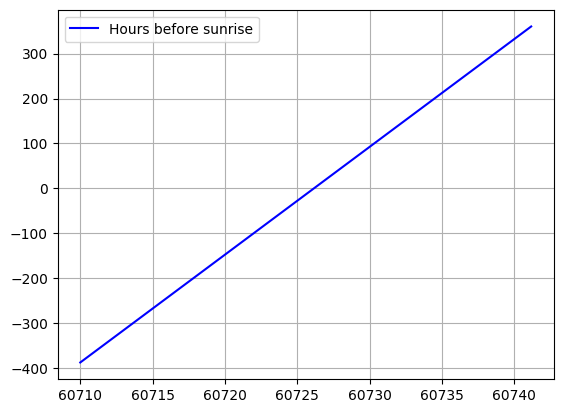

In [4]:
ax=plt.subplot()
ax.plot(mySun.mjd, hrs,                 color="blue",   label="Hours before sunrise")
plt.legend()
plt.grid(True)
plt.show()

Sunrise: 60726.145833333336
Checking efficiency array size: 2993


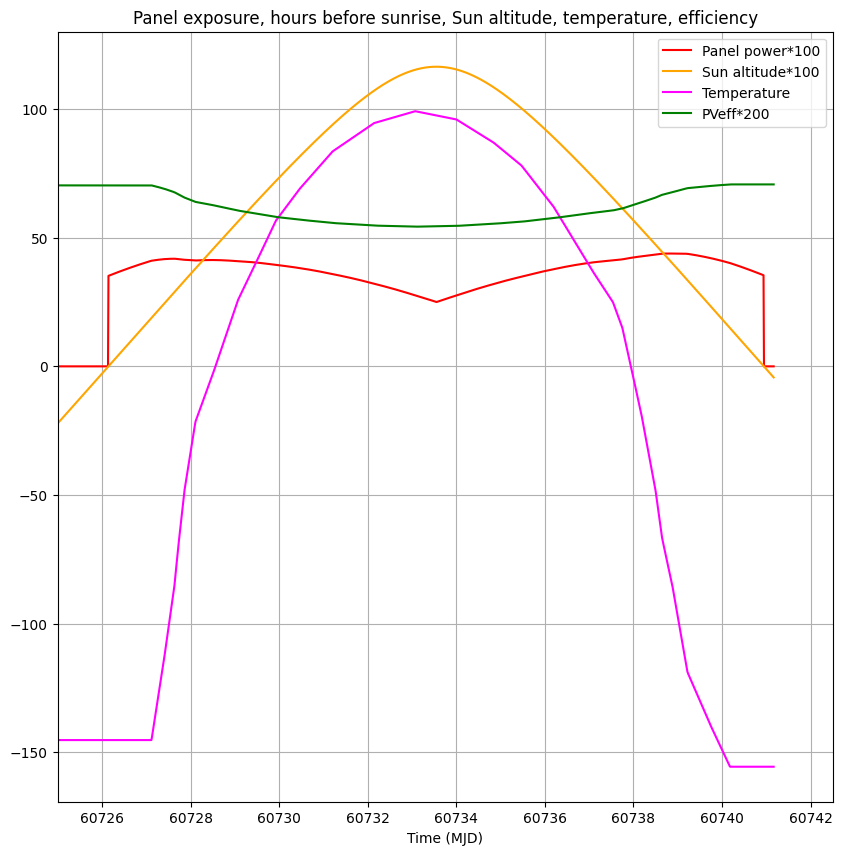

In [5]:
print(f'''Sunrise: {mySun.sunrise}''')

plt.rcParams["figure.figsize"] = [10., 10.]
# plt.rcParams["figure.autolayout"] = True

ax=plt.subplot()

ax.plot(mySun.mjd, ctr.power*100.,  color="red",    label="Panel power*100")
# ax.plot(mySun.mjd, hrs,                 color="blue",   label="Hours before sunrise")
ax.plot(mySun.mjd, mySun.alt*100,       color="orange", label="Sun altitude*100")
ax.plot(mySun.mjd, mySun.temperature,   color="Magenta",label="Temperature")

ax.set_xlabel('Time (MJD)')


eff = Panel.pvEfficiency(mySun.temperature)
print(f'''Checking efficiency array size: {eff.size}''')
ax.plot(mySun.mjd, eff*200., color="green",  label="PVeff*200")

plt.xlim(60725,60742.5)
# plt.ylim(-150,375)
plt.grid(True)
plt.title("Panel exposure, hours before sunrise, Sun altitude, temperature, efficiency")
plt.legend()

plt.show()


---

### Device properties

Device descriptions, such as states and power consumption for each state, can be stored in a _YAML_ file and read into the application.


In [6]:
# Read device configuration
import yaml

device_file = '../config/devices.yml'
print(f'''Reading device profiles from the file "{'../config/devices.yml'}"''')
f = open(device_file, 'r')

device_data = yaml.load(f, Loader=yaml.FullLoader)
profiles    = device_data['devices']
print(profiles.keys())



Reading device profiles from the file "../config/devices.yml"
dict_keys(['controller', 'comms'])


---

### Run the simulation

In [7]:
for device_name in profiles.keys():
    device = Device(device_name, profiles[device_name])
    ctr.add_device(device)

ctr.set_device_state('controller', 'ON')

print('List added devices:')
for added_device in ctr.devices.keys():
        dvc = ctr.devices[added_device]
        print(dvc.name, dvc.state)

env.process(ctr.run())
env.run(until=mySun.N)


List added devices:
controller ON
comms OFF


---

### Plot the results

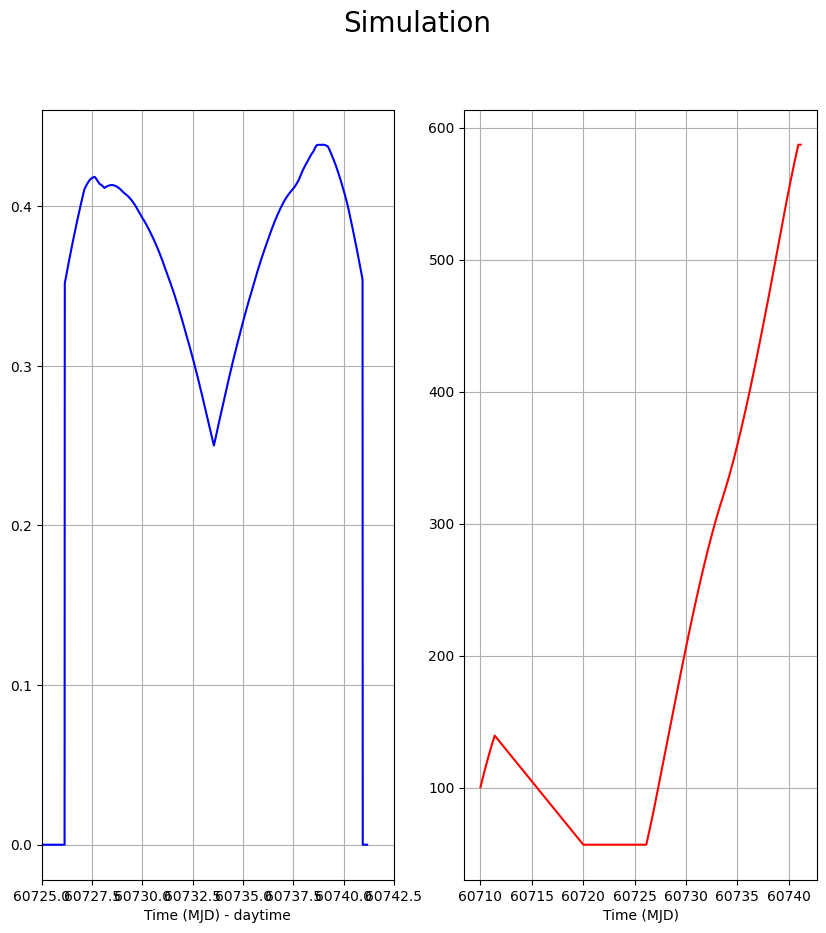

In [8]:
fig, (p1, p2) = plt.subplots(1,2)
fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD) - daytime')
p2.set_xlabel('Time (MJD)')

p1.plot(mySun.mjd, ctr.power,  color="blue",   label="Panel exposure (area units)")
p2.plot(mySun.mjd, ctr.monitor.battery, color="red",    label="Panel power (a.u.)")


p1.set_xlim([60725,60742.5])

p1.grid(True)
p2.grid(True)

plt.show()



